# ECE 498 DS Mini Project 2 - Template

mananm2, somani4, gowtham4

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st
%matplotlib inline

# Task 1: Data Cleaning and Visual Inspection

## 0. Getting Started With the Data

In [2]:
df_he0 = pd.read_csv('Data/RelativeAbundance_HE0.csv')
df_he1 = pd.read_csv('Data/RelativeAbundance_HE1.csv')

df_he0.head()

,Microbe Name,HE0Sample_0,HE0Sample_1,HE0Sample_2,HE0Sample_3,HE0Sample_4,HE0Sample_5,HE0Sample_6,HE0Sample_7,HE0Sample_8,...,HE0Sample_754,HE0Sample_755,HE0Sample_756,HE0Sample_757,HE0Sample_758,HE0Sample_759,HE0Sample_760,HE0Sample_761,HE0Sample_762,HE0Sample_763
0,Acidobacteria_Acidobacteria_Gp1_Telmatobacter_...,0.004239,0.004345,0.004423,0.004463,0.005372,0.004136,0.004457,0.004049,0.004638,...,0.004464,0.004636,0.004046,0.005518,0.005073,0.003527,0.005413,0.003140,0.002998,0.004829
1,Acidobacteria_Acidobacteria_Gp3_Gp3_Gp3,0.013269,0.012312,0.011611,0.013033,0.013689,0.012752,0.009772,0.012148,0.013743,...,0.010603,0.013565,0.012139,0.012875,0.013294,0.014107,0.012694,0.013082,0.008244,0.010401
2,Actinobacteria_Actinobacteria_Acidimicrobiales...,0.003502,0.005251,0.006082,0.003749,0.004332,0.004136,0.004972,0.004930,0.004638,...,0.003906,0.002919,0.004782,0.006070,0.003498,0.004408,0.004853,0.004012,0.004310,0.005758
3,Actinobacteria_Actinobacteria_Actinomycetales_...,0.003870,0.005794,0.005345,0.004106,0.002946,0.003963,0.005315,0.003697,0.005326,...,0.005394,0.004979,0.004598,0.005518,0.005597,0.004761,0.004293,0.005233,0.004497,0.005386
4,Actinobacteria_Actinobacteria_Actinomycetales_...,0.004976,0.003802,0.004239,0.004285,0.005198,0.004136,0.003257,0.002993,0.003264,...,0.004092,0.003777,0.004782,0.004598,0.003848,0.004585,0.003360,0.004186,0.004684,0.002043


### 1. In the context of statistical analysis, why do biologists need multiple samples to identify microbes with significantly altered abundance?

### 2. How many samples were analyzed?

In [3]:
len(df_he0.columns) - 1

764

764 samples were analyzed

### 3. How many microbes were identified?

In [4]:
df_he0['Microbe Name'].nunique()

149

149 microbes were identified

## 1. Bayesian Network for Quality Control

### a. Joint Probability Factorization

$$ P(Storage Temp, Collection Method, Contamination, Lab Time, Quality) $$
$$= P(Quality | Contamination, Lab Time) * P(Contamination | Storage Temp, Collection Method) * P(Storage Temp) * P(Collection Method) * P(Lab Time) $$

### b. Parameters Required

Each feature takes 2 posisble values. For the CPTs:

P(Quality | Contamination, Lab Time): 4 parameters

P(Contamination | Storage Temp, Collection Method): 4 parameters

P(Storage Temp): 1 parameters

P(Collection Method): 1 parameters

P(Lab Time): 1 parameters

Thus, we need (4 + 4 + 1 + 1 + 1) = **11 parameters**

### c. Constructing Probability Tables

In [5]:
df_quality = pd.read_csv('Data/QualityControl.csv')
df_quality.head()

,strtmp,coll,labtime,cont,qual
0,cold,nurse,short,low,good
1,cold,nurse,short,low,good
2,cold,nurse,short,low,bad
3,cold,nurse,short,high,good
4,cold,nurse,short,low,good


In [6]:
#P(Storage Temp), P(Collection Method) and P(Lab Time) stored in dictionaries
strtmp = {}
strtmp['cold'] = (df_quality['strtmp'] == 'cold').sum() / len(df_quality)
strtmp['cool'] = (df_quality['strtmp'] == 'cool').sum() / len(df_quality)

coll = {}
coll['nurse'] = (df_quality['coll'] == 'nurse').sum() / len(df_quality)
coll['patient'] = (df_quality['coll'] == 'patient').sum() / len(df_quality)

labtime = {}
labtime['short'] = (df_quality['labtime'] == 'short').sum() / len(df_quality)
labtime['long'] = (df_quality['labtime'] == 'long').sum() / len(df_quality)

print(strtmp,'\n',coll,'\n',labtime)

{'cold': 0.8982, 'cool': 0.1018} 
 {'nurse': 0.8976, 'patient': 0.1024} 
 {'short': 0.7956, 'long': 0.2044}


In [7]:
#P(Quality | Contamination, Lab Time)
quality_cpt = pd.DataFrame(columns = ['cont','labtime','qual = good', 'qual = bad'])
k = 0
for i in df_quality['cont'].unique().tolist():
    for j in df_quality['labtime'].unique().tolist():
        temp = df_quality[(df_quality['cont']==i) & (df_quality['labtime']==j)]
        quality_cpt.loc[k] = [i,j, (temp['qual']=='good').sum()/len(temp), (temp['qual']=='bad').sum()/len(temp)]
        k+=1
print('P(Quality | Contamination, Lab Time)')
quality_cpt

P(Quality | Contamination, Lab Time)


,cont,labtime,qual = good,qual = bad
0,low,short,0.957093,0.042907
1,low,long,0.919003,0.080997
2,high,short,0.935743,0.064257
3,high,long,0.033898,0.966102


In [8]:
#P(Contamination | Storage Temp, Collection Method)
contamination_cpt = pd.DataFrame(columns = ['strtmp', 'coll', 'cont = low', 'cont = high'])
k = 0
for i in df_quality['strtmp'].unique().tolist():
    for j in df_quality['coll'].unique().tolist():
        temp = df_quality[(df_quality['strtmp']==i) & (df_quality['coll']==j)]
        contamination_cpt.loc[k] = [i,j, (temp['cont']=='low').sum()/len(temp), (temp['cont']=='high').sum()/len(temp)]
        k+=1
print('P(Contamination | Storage Temp, Collection Method)')
contamination_cpt

P(Contamination | Storage Temp, Collection Method)


,strtmp,coll,cont = low,cont = high
0,cold,nurse,0.956017,0.043983
1,cold,patient,0.923423,0.076577
2,cool,nurse,0.911565,0.088435
3,cool,patient,0.161765,0.838235


### d. Final Probability Tables

In [9]:
#P(Quality | Storage Temp, Collection Method, Lab Time)
final_cpt = pd.DataFrame(columns = ['strtmp', 'coll', 'labtime', 'qual = good', 'qual = bad'])
l = 0
for i in df_quality['strtmp'].unique().tolist():
    for j in df_quality['coll'].unique().tolist():
        for k in df_quality['labtime'].unique().tolist():
            temp = df_quality[(df_quality['strtmp']==i) & (df_quality['coll']==j) & (df_quality['labtime']==k)]
            final_cpt.loc[l] = [i,j,k, (temp['qual']=='good').sum()/len(temp), (temp['qual']=='bad').sum()/len(temp)]
            l+=1
print('P(Quality | Storage Temp, Collection Method, Lab Time)')
final_cpt

P(Quality | Storage Temp, Collection Method, Lab Time)


,strtmp,coll,labtime,qual = good,qual = bad
0,cold,nurse,short,0.955112,0.044888
1,cold,nurse,long,0.887962,0.112038
2,cold,patient,short,0.943978,0.056022
3,cold,patient,long,0.862069,0.137931
4,cool,nurse,short,0.972376,0.027624
5,cool,nurse,long,0.822785,0.177215
6,cool,patient,short,0.960784,0.039216
7,cool,patient,long,0.117647,0.882353


### e. Cleaning the dataset

In [10]:
df_bi_he0 = pd.read_csv('Data/BayesInferenceHE0.csv')
df_bi_he1 = pd.read_csv('Data/BayesInferenceHE1.csv')
df_bi_he0['qual'], df_bi_he1['qual'] = 0,0

for i in range(len(df_bi_he0)):
    features = df_bi_he0.loc[i,['strtmp','coll','labtime']].tolist()
    for j in range(len(final_cpt)):
        if features == final_cpt.loc[j,['strtmp','coll','labtime']].tolist():
            break
    if final_cpt.loc[j,'qual = good'] > final_cpt.loc[j,'qual = bad']:
        df_bi_he0.loc[i,'qual'] = 'good'
    else:
        df_bi_he0.loc[i,'qual'] = 'bad'


for i in range(len(df_bi_he1)):
    features = df_bi_he1.loc[i,['strtmp','coll','labtime']].tolist()
    for j in range(len(final_cpt)):
        if features == final_cpt.loc[j,['strtmp','coll','labtime']].tolist():
            break
    if final_cpt.loc[j,'qual = good'] > final_cpt.loc[j,'qual = bad']:
        df_bi_he1.loc[i,'qual'] = 'good'
    else:
        df_bi_he1.loc[i,'qual'] = 'bad'


In [11]:
#Report the bad quality data
print('Bad quality samples in HE0 are:')
print(df_bi_he0[df_bi_he0['qual']=='bad']['SampleName'])
print('\nBad quality samples in HE1 are:')
print(df_bi_he1[df_bi_he1['qual']=='bad']['SampleName'])

Bad quality samples in HE0 are:
699    HE0Sample_699
700    HE0Sample_700
701    HE0Sample_701
702    HE0Sample_702
703    HE0Sample_703
704    HE0Sample_704
705    HE0Sample_705
706    HE0Sample_706
707    HE0Sample_707
708    HE0Sample_708
709    HE0Sample_709
710    HE0Sample_710
711    HE0Sample_711
712    HE0Sample_712
713    HE0Sample_713
714    HE0Sample_714
715    HE0Sample_715
716    HE0Sample_716
717    HE0Sample_717
718    HE0Sample_718
719    HE0Sample_719
720    HE0Sample_720
721    HE0Sample_721
722    HE0Sample_722
723    HE0Sample_723
724    HE0Sample_724
725    HE0Sample_725
726    HE0Sample_726
727    HE0Sample_727
728    HE0Sample_728
           ...      
734    HE0Sample_734
735    HE0Sample_735
736    HE0Sample_736
737    HE0Sample_737
738    HE0Sample_738
739    HE0Sample_739
740    HE0Sample_740
741    HE0Sample_741
742    HE0Sample_742
743    HE0Sample_743
744    HE0Sample_744
745    HE0Sample_745
746    HE0Sample_746
747    HE0Sample_747
748    HE0Sample_748
74

In [12]:
#Remove the bad quality data for future use
df_bi_he0 = df_bi_he0[df_bi_he0['qual']=='good']
df_bi_he1 = df_bi_he1[df_bi_he1['qual']=='good']

## 2. Data Standardization

### 1. Verify Relative Abundance

In [110]:
for sample in df_he0.set_index('Microbe Name').columns.tolist():
    if df_he0[sample].sum() != 1:
        df_he0.drop(sample, axis = 1, inplace = True)

for sample in df_he1.set_index('Microbe Name').columns.tolist():
    if df_he1[sample].sum() != 1:
        df_he1.drop(sample, axis = 1, inplace = True)

### 2. Discussion on Relative Abundance Data

## 3. Visual Inspection

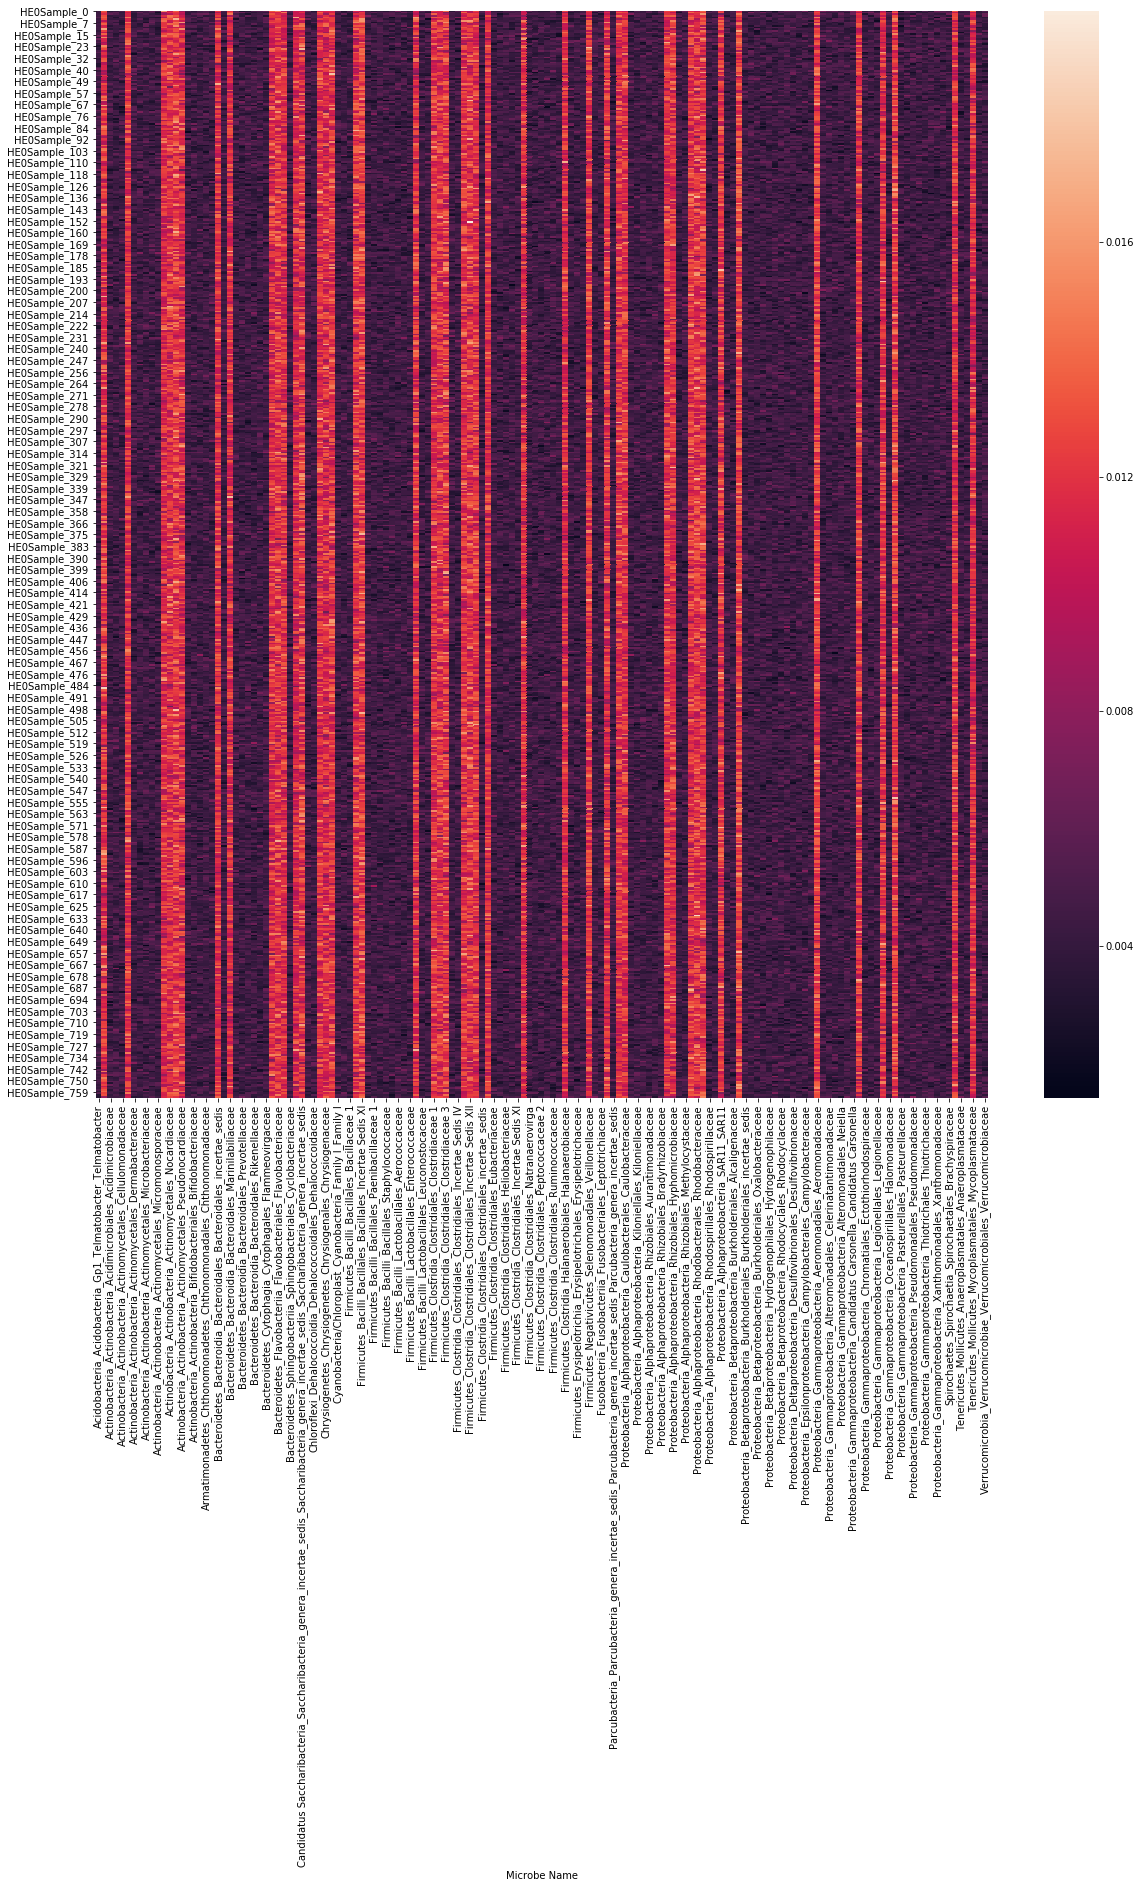

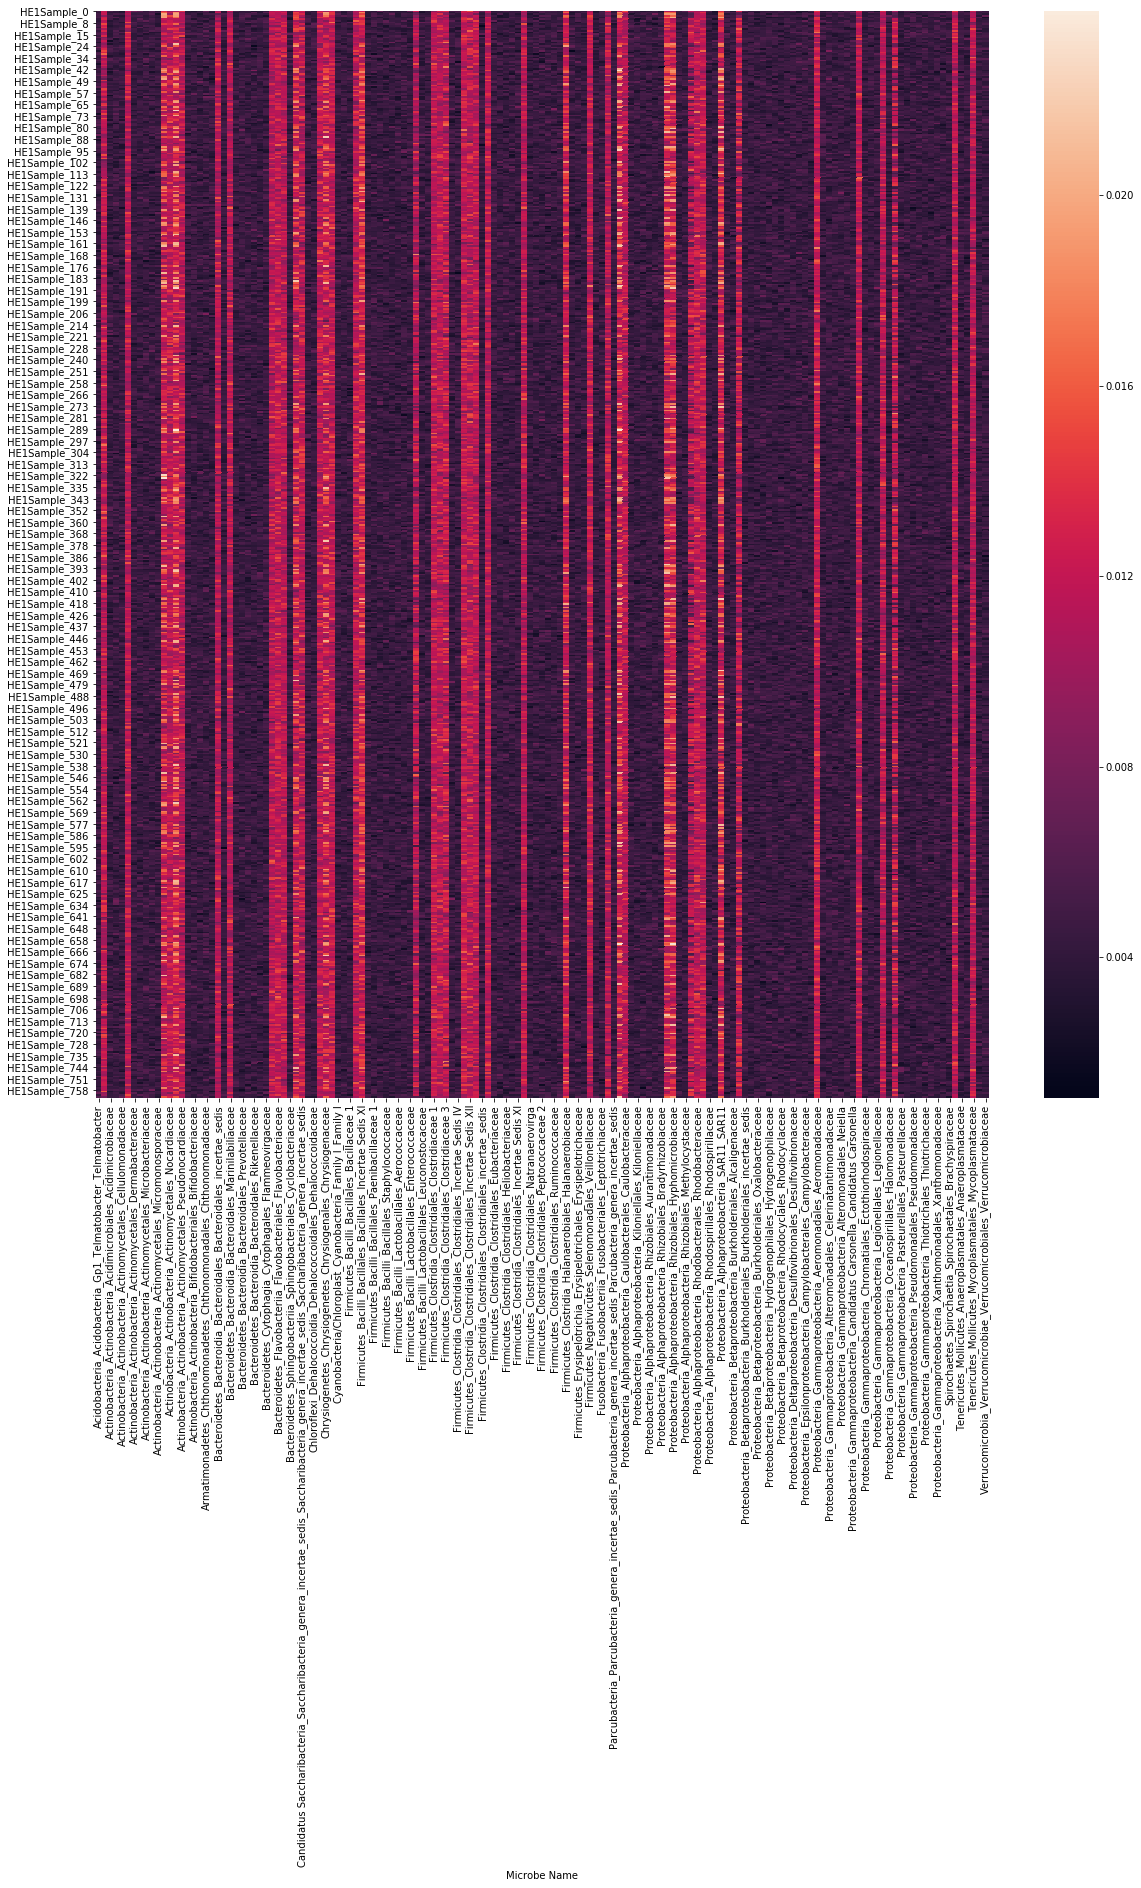

In [14]:
plt.figure(figsize = (20,20))
sns.heatmap(df_he0.set_index('Microbe Name').transpose())
plt.show()

plt.figure(figsize = (20,20))
sns.heatmap(df_he1.set_index('Microbe Name').transpose())
plt.show()

# Task 2: Statistical Analysis

## 1. Kolmogorov-Smirnov (KS) Test

### a. p-value for Two-Sample KS Test

In [29]:
#Contingency check to make sure the microbes are the same and in the same order
df_he0['Microbe Name'].tolist() == df_he1['Microbe Name'].tolist()

True

In [34]:
pvalue_dict = {}
for i in range(len(df_he0)):
    microbe = df_he0.loc[i,'Microbe Name']
    he0 = df_he0.loc[i].tolist()[1:]
    he1 = df_he1.loc[i].tolist()[1:]
    _, p = st.ks_2samp(he0, he1)
    pvalue_dict[microbe] = p

### b. Null Hypothesis of the KS Test in our Context

$H_0$ for the KS Test is that the 2 samples tested are drawn from the same underlying distribution. In our context, it can be interpreted as no significantly altered expression of a particular microbe in the stool samples from HE0 and HE1 patients.

Example of a particular microbe...

### c. Number of Genes with Significantly Altered Expression at Various Alpha Values

In [36]:
count_dict = {}
count_dict['0.1'] = sum(1 for i in pvalue_dict.values() if i < 0.1)
count_dict['0.05'] = sum(1 for i in pvalue_dict.values() if i < 0.05)
count_dict['0.01'] = sum(1 for i in pvalue_dict.values() if i < 0.01)
count_dict['0.005'] = sum(1 for i in pvalue_dict.values() if i < 0.005)
count_dict['0.001'] = sum(1 for i in pvalue_dict.values() if i < 0.001)
count_dict

{'0.1': 43, '0.05': 38, '0.01': 25, '0.005': 24, '0.001': 20}

## 2. Multiple Testing

### a. P-value

P-value, in general, is the probability of observing the test statistic or a more extreme value **assuming $H_0$ is true**.

In our context, a p-value of 0.05 represents a 5% probability of observing the KS test statistic, given that there is no significantly altered expression of the microbe in the HE0 and HE1 samples.

### b. P-value Distribution

If the null hypothesis is true, the p-values will follow a **unifom distribution**. The reason is how we define $\alpha$ as the probability of erroneously rejecting $H_0$. We reject $H_0$ when p-value < $\alpha$ and the only way this holds for any value of $\alpha$ is when p is uniformly distributed.

### c. Expected Number of Significant p-values

If no microbe's abundance was altered, which is to say that $H_0$ is true, the significant p-values will be uniformly distributed. Thus, for an $\alpha$ value of 0.1, we expect to see 10% of the total number of samples (and so on).

(We round the number of microbes to 150 instead of 149 here)

| Alpha Level | # of Significant p-values if $H_0$ true | # observed from data in Task 2.1.c |
| --- | --- | --- |
| 0.1 | 15 | 43 |
| 0.05 | 8 | 38 |
| 0.01 | 2 | 25 |
| 0.005 | 1 | 24 |
| 0.001 | 0 | 20 |

### d. Q-Q plot of p-values

#### i. 

In [106]:
#Sample N p-values from a uniform distribution (N = 149)
expected_pvalues = np.random.uniform(0,1,149).tolist()
observed_pvalues = list(pvalue_dict.values())

#### ii. 

In [107]:
expected_log = -np.log10(expected_pvalues)
observed_log = -np.log10(observed_pvalues)

#### iii. 

In [108]:
expected_log = np.sort(expected_log)
observed_log = np.sort(observed_log)

#### iv. v. and vi.

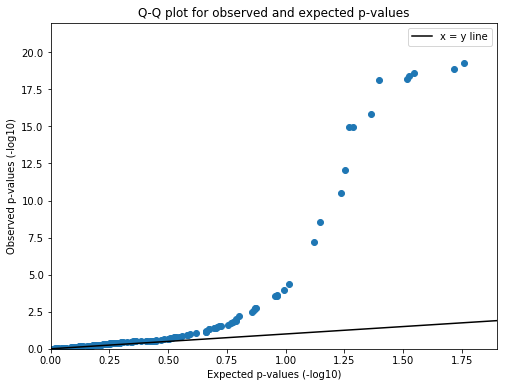

In [109]:
plt.figure(figsize = (8,6))
plt.scatter(expected_log, observed_log)
plt.title('Q-Q plot for observed and expected p-values')
plt.xlabel('Expected p-values (-log10)')
plt.ylabel('Observed p-values (-log10)')
plt.xlim([0,1.9])
plt.ylim([0,22])
#plot x = y line
#plot the limits against each other
plt.plot([0,22],[0,22], label = 'x = y line', color = 'black')
plt.legend()

plt.show()

### e. Follow-up Questions

#### i. To be answered

#### ii. To be answered

# Task 3: Dimensionality Reduction and Clustering

## 1. PCA

### a. Performing PCA


### b. Ordering Components

### c. Scatter Plot of Microbe Abundance

## 2. t-SNE

### a. Performing t-SNE

### b. Comparing with PCA

## 3. Clustering

### a. K-Means

### b. GMM

### c. Single and Complete Linkage Hierarchical

### d. Single vs Complete Link Hierarchical Clustering

### e. Comparing Clustering Techniques

### f. What do Clusters Represent

### g. Deciding on Number of Clusters

# Task 4: Interpreting Results

## 1. Identify Microbes with Altered Abundance Levels

### a. Determine if each HE1 Subpopulation shows altered abundance levels

### b. Identify Most Similar HE0 Clusters to Affected HE1 Clusters

### c. Identify Microbes with Significantly Altered Relative Abundance

## 2. Identify How Abundance Changes

### a. Microbes which increase and decrease

### b. Biological Relations